<a href="https://colab.research.google.com/github/lior9005/deep-learning/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADL final project


---


**Authors:**
> Lior Sharony 316380138


> Noam Zigler 314868019


> Eden Miran 208742429


In [52]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split, Subset, Dataset, SubsetRandomSampler
from tqdm.auto import tqdm

# Eval mode
eval_mode = False
ood_as_fashion = True #define the ood
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data & Preprocessing

In [37]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10



def eval_model(model, data_loader, device):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            ### Modify output if needed ###
            data = data.view(-1, 28*28)
            # Model outputs
            outputs = model(data)


            # y pred should be a vector of size (N_batch,) -> [5, 2, ..., 10]
            # and not one-hot. You can handle this either in your model or here.

            # Assuming the model returns an (N_batch, 11) size output
            probas, y_pred = torch.max(outputs, 1)

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot!
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total

In [45]:
# Transformers
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
ood_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.5,), (0.5,))
])

# Mnist dataset
mnist_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

# Train on a random subset of 10k examples
N = 10000
torch.manual_seed(0)
np.random.seed(0)

train_size = len(mnist_train_set)
mnist_val_size = int(train_size * 0.2)
mnist_train_size = train_size - mnist_val_size
mnist_train_dataset, mnist_val_dataset = random_split(mnist_train_set, [mnist_train_size, mnist_val_size])

train_idx = np.arange(len(mnist_train_dataset))
train_subset_idx = np.random.choice(train_idx, N)
train_subset_sampler = SubsetRandomSampler(train_subset_idx)

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=512, sampler=train_subset_sampler)
mnist_val_loader = DataLoader(mnist_val_dataset, batch_size=512, shuffle=False)
mnist_test_loader = DataLoader(mnist_test_set, batch_size=1000, shuffle=False)

# Ood
if(ood_as_fashion):
  ood = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=ood_transform)
else:
  ood = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=ood_transform)

# Generating the combined dataset
ood_indices = np.random.choice(len(ood), 2000, replace=False)
ood_subset = Subset(ood, ood_indices)
combined_ds = CombinedDataset(mnist_test_set, ood_subset)

combined_ds_loader = DataLoader(combined_ds, batch_size=1024, shuffle=True)

# Models

In [43]:
# Baseline model class
class Baseline_model(nn.Module):
  def __init__(self):
        super(Baseline_model, self).__init__()
        self.clf =nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
  def forward(self,x):
      preds = self.clf(x)
      return preds


# OSR model class



# Training

Training MNIST MLP:   0%|          | 0/20 [00:00<?, ?it/s]

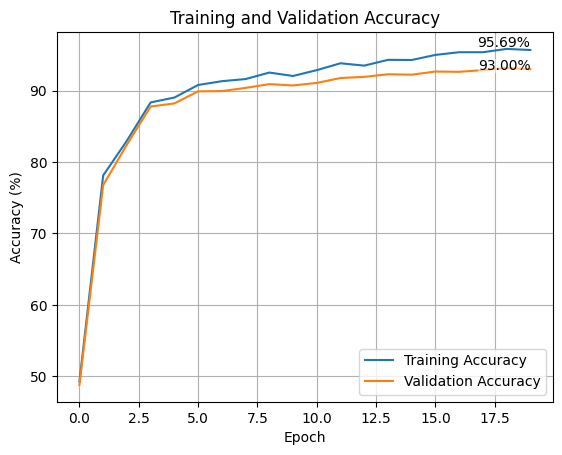

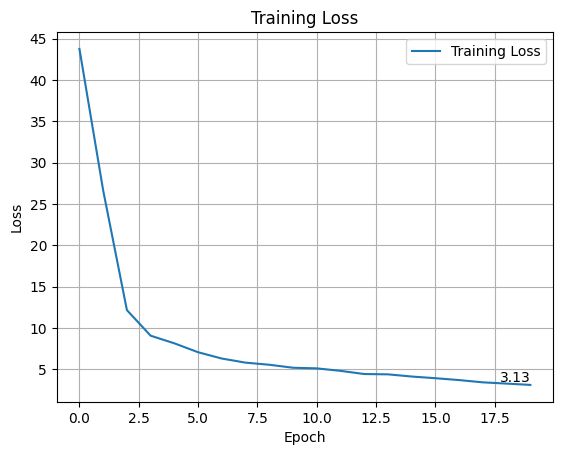

In [63]:
if not (eval_mode):
  baseline_num_epoch = 20

  def evaluate_accuracy(model, data_loader, device):
      correct = 0
      total = 0
      with torch.no_grad():  # Disable gradient calculation for evaluation
          for data in data_loader:
              inputs, labels = data
              inputs = inputs.view(inputs.shape[0], -1).to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)  # Get predicted labels

              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      accuracy = 100 * correct / total
      return accuracy

  # Training procedure - baseline model
  def train_baseline_model(trainloader, num_epochs):
    model = Baseline_model()
    optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9) #how it should be the best
    model.to(device)
    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = [] #??????
    criterion = nn.NLLLoss()
    for epoch in tqdm(range(num_epochs), desc="Training MNIST MLP"):
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          inputs = inputs.view(inputs.shape[0], -1)
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = model.forward(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
      train_loss_list.append(running_loss)
      train_acc = evaluate_accuracy(model, trainloader, device)
      train_acc_list.append(train_acc)
      val_acc = evaluate_accuracy(model, mnist_val_loader, device)
      val_acc_list.append(val_acc)
    return model, train_loss_list,train_acc_list, val_acc_list

  # Training procedure - osr model



  # Training and validation loss and accuracy for MNIST plot - baseline model
  criterion = nn.NLLLoss()
  baseline_model, train_loss_list, train_acc_list, val_acc_list = train_baseline_model(mnist_train_loader, baseline_num_epoch)

  plt.plot(train_acc_list, label='Training Accuracy')
  plt.plot(val_acc_list, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.grid(True)
  final_train_acc = train_acc_list[-1]
  final_val_acc = val_acc_list[-1]
  offset = 0.5
  plt.text(len(train_acc_list) - 1, final_train_acc, f'{final_train_acc:.2f}%', ha='right', va='bottom')
  plt.text(len(val_acc_list) - 1, final_val_acc - offset, f'{final_val_acc:.2f}%', ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0))
  plt.show()

  plt.plot(train_loss_list, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.legend()
  plt.grid(True)
  final_train_loss = train_loss_list[-1]
  plt.text(len(train_loss_list) - 1, final_train_loss, f'{final_train_loss:.2f}', ha='right', va='bottom')
  plt.show()

  # Training and validation loss and accuracy for MNIST plot - osr model





  torch.save(baseline_model.state_dict(), './baseline model.pth')


# Evaluation - CIFAR10/Fashion-MNIST

In [ ]:
if (eval_mode):
    # Load the trained models weights
    baseline_model = Baseline_model()  # Create an instance of the model
    baseline_model.load_state_dict(torch.load('./baseline_model.pth'))  # Load the weights
    baseline_model.to(device)  # Move the model to the device (CPU or GPU)
    baseline_model.eval()  # Set the model to evaluation mode


# Baseline results


**OSR approach:**

---



In [ ]:
# OOD results


# OSR results


# t-SNE and/or PCA visualization (optional)


# Additional figures (optional)

# Evaluation - Unknown Dataset

In [ ]:
# placeholder for the combined OSR dataset and dataloader


# Load the trained models weights


# OOD results


# OSR results